<a href="https://colab.research.google.com/github/serg-kas/NN-archive/blob/main/%D0%90%D0%BF%D1%80%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D1%83%D1%80%D1%81_2020_Light_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_27_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Light задание. 

**Вариант 1**
 
Сделайте свою собственную архитектуру и запустите, оцените точность на проверочной выборке
Возьмите “лучшую” архитектуру и проведите несколько экспериментов, меняя гиперпараметры выбранной архитектуры.
Напишите ваши выводы
 

### Подключение библиотек

In [ ]:
!pip install pymorphy2                                                          # Установка pymorphy2

     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 8.2MB 7.1MB/s 


In [ ]:
import numpy as np                                                              # Библиотека для работы с массивами данных
import pandas as pd                                                             # Для работы с DataFrame

from tensorflow.keras.models import Model, load_model                           # Импортируем модель, метод загрузки предобученной сети 
from tensorflow.keras.preprocessing.text import Tokenizer                       # Работа с текстами и преобразования их в последовательности

# Импортируем слои для сеток
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling1D, Conv1D, Conv2DTranspose, Lambda

from tensorflow.keras import backend as K                                       # Импортируем для подсчета dice_coef
from tensorflow.keras.optimizers import Adam, Adadelta                          # Импортируем оптимизаторы 
from tensorflow.keras import utils                                              # Импортируем для работы с категориальными данными 

from gensim.models import word2vec                                              # Импортируем gensim 
import pymorphy2                                                                # Импортируем для работы с леммами

import re                                                                       # Импортируем для работы со строками
import time                                                                     # Импортируем для подсчета времени
import random

from google.colab import files                                                  # Импортируем для работы с файлами
import os                                                                       # Импортируем для работы с файловой системой

import matplotlib.pyplot as plt                                                 # Импортируем для отрисовки графиков
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Функции для работы с текстом


In [ ]:
######################################################
# Чтение текста из файла, очистка от знаков препинания
######################################################

def readText(fileName):
  f = open(fileName, 'r')                  # Открываем наш файл для чтения и считываем из него данные 
  text = f.read()                          # Записываем прочитанный текст в переменную 
  
  # Определяем символы для удаления
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";", ":", "[", "]" ]

  for dS in delSymbols:                    # Каждый символ в списке символов для удаления
    text = text.replace(dS, " ")           # Удаляем, заменяя на пробел

  # Ищем шаблоны и символы в строке и меняем на указанную подстроку
  # ЧТОБЫ ПЕРЕД И ПОСЛЕ ТЭГОВ БЫЛ ПРОБЕЛ
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # Метод split разделит текст по пробелам (их может быть несколько после удаления символов)
  # При помощи метода join запишем все разделенные слова снова в строку
  text = ' '.join(text.split()) 
  text = text.lower()                     # Переводим текст в нижний регистр

  return text                             # Возвращаем текст


#####################################################################
# Преобразование исходного текста в список из слов в нормальной форме
#####################################################################

def text2Words(text):

  morph = pymorphy2.MorphAnalyzer()       # Создаем экземпляр класса MorphAnalyzer
  words = text.split(' ')                 # Разделяем текст на пробелы
  #Переводим каждое слово в нормальную форму  
  words = [morph.parse(word)[0].normal_form for word in words] 

  return words                            # Возвращаем слова


### Чтение данных 



In [ ]:
# Путь к папке с договорами
directory = '/content/drive/My Drive/my_sample_data/Д.З.27/Договоры 432/'

# Выведем названия 5-ти договоров
for i in range(250,255): print(os.listdir(directory)[i])

print('Всего', len(os.listdir(directory)), 'договора.')

dogovor-zaloga-privatizirovannoy-kvartiri.txt
dogovor-zaloga-s-peredachej-predmeta-zaloga-zalogoderzhatelyu.txt
dogovor-zaloga-nedvizhimosti.txt
dogovor-zaloga-imuschestvennih-prav.txt
dogovor-zaloga-imuschestva-kvartiri.txt
Всего 432 договора.


In [ ]:
# Список, в который запишем договоры как
# список строк (строка = договор)
agreements = []

curTime = time.time()                                    # Засечем текущее время
# Проходим по всем файлам в директории договоров
for filename in os.listdir(directory): 
  txt = readText(directory + filename)                   # Читаем текст договора
  if txt != '':                                          # Если текст не пустой
    agreements.append(readText(directory + filename))    # Преобразуем файл в одну строку и добавляем в agreements

print('На обработку ушло:', round(time.time() - curTime, 2), 'с.')

На обработку ушло: 157.93 с.


In [ ]:
# Список, в который запишем договоры как
# список списков строк (строка = слово)
words = [] 

curTime = time.time()                                     # Засечем текущее время
# Проходимся по всем договорам
for i in range(len(agreements)): 
  words.append(text2Words(agreements[i]))                 # Преобразуем очередной договор в список слов и добавляем в words

print('На преобразование ушло:', round(time.time() - curTime, 2), 'с.')

На преобразование ушло: 156.42 с.


In [ ]:
# Отделяем тексты для тестовой выборки
wordsToTest = words[-10:]                                 # 10 текстов для финальной проверки обученной нейронной сети 
words = words[:-10]                                       # остальные тексты для обучающей и проверочной выборок

print('Количество текстов в выборке для финальной проверки:', len(wordsToTest)) 
print('Количество договоров, взятых для обучающей и тестовой выборки:',len(words)) 

Количество текстов в выборке для финальной проверки: 10
Количество договоров, взятых для обучающей и тестовой выборки: 412


In [ ]:
print('Пример исходного текста:')
print(agreements[4][:62], '\n')
print('Тот же текст, представленный в виде списка из слов в начальной форме:')
print(words[4][:10])

Пример исходного текста:
договор бартера г г в лице действующего на основании именуемый 

Тот же текст, представленный в виде списка из слов в начальной форме:
['договор', 'бартер', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать']


### Преобразование текста в индексы: формирование xTrain

In [ ]:
# lower=True - приводим слова к нижнему регистру
# filters='' - фильтровать символы не надо, все уже выкинуто
# char_level=False - просим токенайзер учитывать слова, а не отдельные символы
tokenizer = Tokenizer(lower=True, filters = '', char_level=False)

tokenizer.fit_on_texts(words)                                                   # "Скармливаем" наши тексты

clean_voc = {} 
for item in tokenizer.word_index.items():                                       # Преобразуем полученный список в словарь
  clean_voc[item[0]] = item[1]                                                   

print('Словарь всех слов по частоте:') 
print(clean_voc, '\n')
print('Длинна словаря:', len(clean_voc))

Словарь всех слов по частоте:
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'сторона': 7, 'настоящий': 8, 'с': 9, 'на': 10, '3': 11, '<s1>': 12, '</s1>': 13, 'не': 14, '4': 15, 'или': 16, 'за': 17, 'он': 18, 'случай': 19, 'о': 20, '5': 21, '•': 22, '<s3>': 23, '</s3>': 24, 'право': 25, 'работа': 26, 'срок': 27, 'от': 28, '<s4>': 29, '</s4>': 30, 'они': 31, 'при': 32, '6': 33, 'лицо': 34, 'имущество': 35, 'арендатор': 36, 'быть': 37, 'другой': 38, 'день': 39, 'действовать': 40, 'для': 41, 'условие': 42, '7': 43, 'если': 44, 'к': 45, 'п': 46, 'дальнейший': 47, 'который': 48, 'обязательство': 49, 'а': 50, 'страховой': 51, 'сумма': 52, 'порядок': 53, 'законодательство': 54, 'арендодатель': 55, 'работник': 56, 'действие': 57, 'указанный': 58, 'счёт': 59, 'свой': 60, 'размер': 61, 'соответствие': 62, 'именовать': 63, 'из': 64, 'мочь': 65, 'обязать': 66, 'страховщик': 67, 'исполнение': 68, 'один': 69, 'основание': 70, 'страхователь': 71, 'обязанность': 72, 'иной': 73, 'год': 74, 'вп

In [ ]:
tag = '<s1>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

Индекс тега <s1> : 12


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
tok_agreem = tokenizer.texts_to_sequences(words) 

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", words[4][:20])
print("Он же в виде последовательности индексов: ", tok_agreem[4][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               ['договор', 'бартер', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'сторона', '1', 'с', 'один', 'сторона', 'и', 'в', 'лицо']
Он же в виде последовательности индексов:  [2, 4180, 77, 77, 1, 34, 40, 10, 70, 63, 1, 47, 7, 5, 9, 69, 7, 3, 1, 34] 



### Формирование yTrain

In [ ]:
########################################################################
#Каждому индексу (слову) из договора необходимо поставить в соответсвие 
#вектор из 6-ти элементов, соответствующих тегам категорий
########################################################################

# Собираем список индексов и dummy encoded вектора
def get01XSamples(tok_agreem, tags_index):
  tags01 = []                                                                   # Список для тегов
  indexes = []                                                                  # Здесь будут лежать индексы
 
  for agreement in tok_agreem:                                                  # Проходимся по каждому договору-списку
    # Создаем вектор [0,0,0,0,0,0]
    tag_place = [0, 0, 0, 0, 0, 0]                                              
    # Проходимся по каждому слову договора
    for ex in agreement:                                                       
        if ex in tags_index:                            # Смотрим, если индекс оказался нашим тегом
          place = np.argwhere(tags_index==ex)           # Записываем под каким местом лежит этот тег в своем списке
          if len(place)!=0:                             # Проверяем, чтобы тег действительно был
            if place[0][0]<6:                           # Первые шесть тегов в списке - открывающие
              tag_place[place[0][0]] = 1                # Поэтому ставим 1
            else: 
              tag_place[place[0][0] - 6] = 0            # Остальные теги закрывающие, так что меняем на ноль
        else:          
          # Расширяем наш список с каждой итерацией. Получаем в конце длинный список из всех тегов в одном 
          tags01.append(tag_place.copy()) 
          indexes.append(ex)                            # Докидываем индекс слова в список индексов

  return indexes, tags01


# Получение списка слов из индексов
def reverseIndex(clean_voc, x):

  reverse_word_map = dict(map(reversed, clean_voc.items()))      # Берем пары значений всего словаря и размечаем наоборот, т.е. value:key
  words = [reverse_word_map.get(letter) for letter in x]         # Вытаскиваем по каждому ключу в список

  return words # Возвращаем полученный текст

In [ ]:
# s1 Условия
# s2 Запреты
# s3 Стоимость, всё про цены и деньги
# s4 Всё про сроки
# s5 Неустойка
# s6 Всё про адреса и геолокации

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)]                         # Получаем список открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)]                         # Получаем список закрывающих тегов
tags_index.extend(closetags)                                                    # Объединяем все теги

tags_index = np.array([clean_voc[i] for i in tags_index])                       # Получаем из словаря частотности индексы всех тегов
print('Индексы тегов:', tags_index)

Индексы тегов: [ 12 350  23  29 118 274  13 358  24  30 119 265]


In [ ]:
# Распознаем теги и создаем список с ними, с индексами
xData, yData = get01XSamples(tok_agreem,tags_index) 
# Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова
decoded_text = reverseIndex(clean_voc, xData) 

print('Длина xData:', len(xData))
print('Длина yData:', len(yData))

Длина xData: 411870
Длина yData: 411870


In [ ]:
print('Посмотрим на исходный набор слов: ', words[0][50:80])
print('Посмотрим на декодированный текст:', decoded_text[50:80])
print('Посмотрим на часть из xData:     ', xData[50:80])
print('Посмотрим на часть из yData:     ', yData[50:80])

Посмотрим на исходный набор слов:  ['1', 'предмет', 'договор', '1', '1', '<s1>', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '</s1>', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по']
Посмотрим на декодированный текст: ['1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор']
Посмотрим на часть из xData:      [5, 108, 2, 5, 5, 6, 8, 2, 220, 115, 914, 315, 124, 18, 240, 3, 539, 242, 315, 1, 411, 5, 4, 240, 299, 10, 159, 6, 8, 2]
Посмотрим на часть из yData:      [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0],

### Разделение выборки на окна


In [ ]:
# Формируем выборку из индексов
def getSetFromIndexes(wordIndexes, xLen, step): 

  xBatch = []                                         # Лист для фрагментов текста
  wordsLen = len(wordIndexes)                         # Определяем длинну текста
  index = 0                                           # Задаем стартовый индекс
  
  while (index + xLen <= wordsLen):                   # Пока сумма индекса с длинной фрагмента меньше или равна числу слов в выборке
    xBatch.append(wordIndexes[index:index+xLen])      # Добавляем X в лист фразментов текста
    index += step                                     # Сдвигаемся на step

  return xBatch                                       # Лист для фрагментов текста

In [ ]:
xLen = 256                                            # Длина окна
step = 30                                             # Шаг 
embeddingSize = 300                                   # Количество измерений для векторного пространства

In [ ]:
# Генерируем наборы с заданными параметрами окна
xTrain = getSetFromIndexes(decoded_text, xLen, step)  # Последовательность из xLen слов
yTrain = getSetFromIndexes(yData, xLen, step)         # Последовательность из xLen-тегов

In [ ]:
print('Длинна xTrain:', len(xTrain))
print('Длинна yTrain:', len(yTrain))
print('Длинна примера из xTrain:',len(xTrain[0]))
print('Длинна примера из yTrain:',len(yTrain[0]), '\n')
print('Пример xTrain', xTrain[0])
print('Пример yTrain', yTrain[0], '\n')

print('Первый пример xTrain:', xTrain[0][step-5:step+5])
print('Второй пример xTrain:', xTrain[1][:10])

Длинна xTrain: 13721
Длинна yTrain: 13721
Длинна примера из xTrain: 256
Длинна примера из yTrain: 256 

Пример xTrain ['договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'поклажедатель', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор', 'следующий', 'вещь', 'далее', 'вещь', '1', '3', 'при', 'передача', 'вещь',

### Функция подсчета ошибки



In [ ]:
##################################################
# Функция, которая смотрит на пересечение областей
##################################################

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

### Функция для создания PSPnet-сети

In [ ]:
##################################
# Функция для создания PSPnet-сети
##################################

def create_PSPNet(conv_size = 64, num_classes = 6, input_shape = (30, 300)):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    img_input = Input(input_shape)

    # Block 1
    x = Conv1D(conv_size, 3, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(conv_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.7)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.7)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.7)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.7)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.7)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(x_mp_2,conv_size, 2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(x_mp_4,conv_size, 4, strides=4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(x_mp_8,conv_size, 8, strides=8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(x_mp_16,conv_size, 16, strides=16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(x_mp_32,conv_size, 32, strides=32)
    x_mp_32 = Activation('relu')(x_mp_32)


    fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adadelta(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

### Создание xTrain и  yTrain при помощи метода Word2wec GENSIM

In [ ]:
# Создаем выборки
def getSets(model, senI, tagI):
  xVector = []                                    # Здесь будет лежать embedding представление каждого из индексов
  tmp = []                                        # Временный список
  for text in senI:                               # Проходимся по каждому тексту-списку
    tmp=[]
    for word in text:                             # Проходимся по каждому слову в тексте-списке
      tmp.append(model[word]) 

    xVector.append(tmp)

  return np.array(xVector), np.array(tagI)

In [ ]:
# Передаем в word2vec списки списков слов для обучения
# size = embeddingSize - размер эмбеддинга
# window = 10 - минимальное расстояние между словами в эмбеддинге 
# min_count = 1 - игнорирование всех слов с частотой, меньше, чем 1
# workers = 10 - число потоков обучения эмбеддинга
# iter = 10 - число эпох обучения эмбеддинга

modelGENSIM = word2vec.Word2Vec(xTrain, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10)

In [ ]:
xTrainGENSIM, yTrainGENSIM = getSets(modelGENSIM, xTrain, yTrain)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
print('Размерность полученного xTrain:', xTrainGENSIM.shape)
print('Размерность полученного yTrain:', yTrainGENSIM.shape)

Размерность полученного xTrain: (13721, 256, 300)
Размерность полученного yTrain: (13721, 256, 6)


### Сохранение массивов из оперативной памяти в память runtime 


In [ ]:
np.save('xTrainGENSIM.npy', xTrainGENSIM)         #Сохраняем массивы в память колаба
np.save('yTrainGENSIM.npy', yTrainGENSIM)         #Сохраняем массивы в память колаба

In [ ]:
xTrainGENSIM = np.load('xTrainGENSIM.npy')        #Загружаем массивы из памяти колаба
yTrainGENSIM = np.load('yTrainGENSIM.npy')        #Загружаем массивы из памяти колаба

### **PSPnet**


In [ ]:
model_b_PSPnet = create_PSPNet(input_shape=(xLen, embeddingSize))
model_b_PSPnet.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 256, 64)      57664       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 256, 64)      256         conv1d_30[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 256, 64)      0           batch_normalization_12[0][0]     
_______________________________________________________________________________________

In [ ]:
history = model_b_PSPnet.fit(xTrainGENSIM, yTrainGENSIM, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
337/337 [==============================] - 5s 15ms/step - loss: 1.3013 - dice_coef: 0.2012 - val_loss: 1.3340 - val_dice_coef: 0.2020
Epoch 2/500
337/337 [==============================] - 5s 14ms/step - loss: 1.2774 - dice_coef: 0.2069 - val_loss: 1.3155 - val_dice_coef: 0.2065
Epoch 3/500
337/337 [==============================] - 5s 14ms/step - loss: 1.2528 - dice_coef: 0.2130 - val_loss: 1.2928 - val_dice_coef: 0.2120
Epoch 4/500
337/337 [==============================] - 5s 14ms/step - loss: 1.2280 - dice_coef: 0.2195 - val_loss: 1.2698 - val_dice_coef: 0.2177
Epoch 5/500
337/337 [==============================] - 5s 14ms/step - loss: 1.2037 - dice_coef: 0.2261 - val_loss: 1.2475 - val_dice_coef: 0.2236
Epoch 6/500
337/337 [==============================] - 5s 14ms/step - loss: 1.1798 - dice_coef: 0.2329 - val_loss: 1.2255 - val_dice_coef: 0.2296
Epoch 7/500
337/337 [==============================] - 5s 14ms/step - loss: 1.1569 - dice_coef: 0.2397 - val_loss: 1.2050 - 

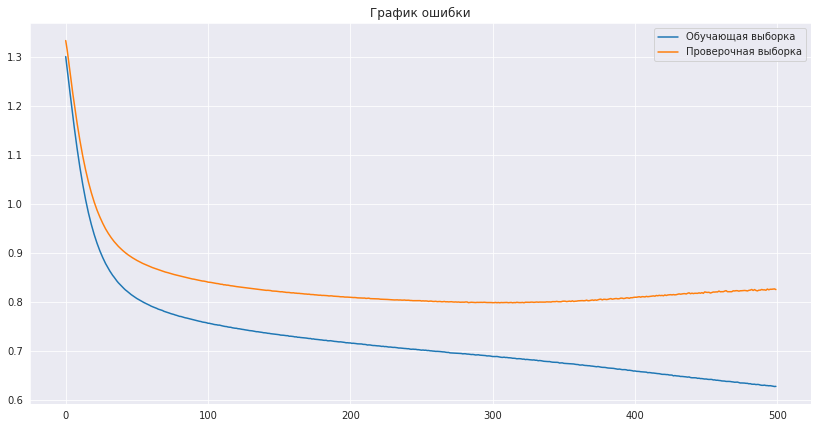

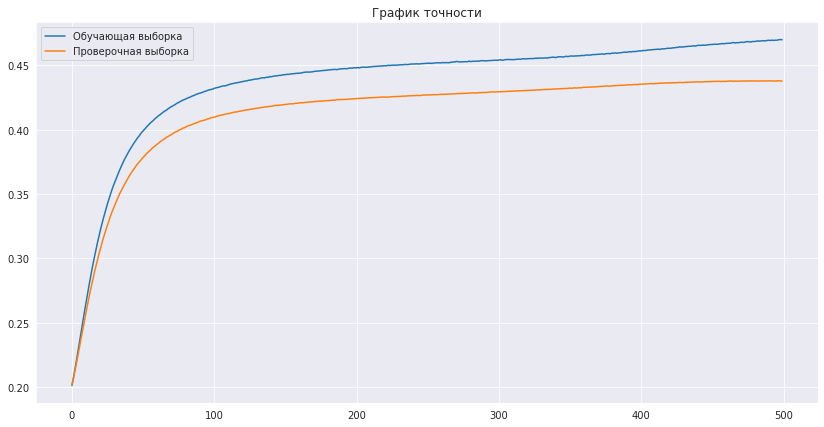

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

In [ ]:
#model_b_PSPnet.save_weights('/content/drive/My Drive/my_sample_data/Д.З.27/model_segment_text.h5')

### Проверка работы сети

In [ ]:
#####################################################################
# Функция, выводящая точность распознавания каждой категории отдельно
#####################################################################

def recognizeSet(tagI, pred, tags, length, value):
  total=0

  for j in range(6):                                            # общее количество тегов
    correct=0
    for i in range(len(tagI)):                                  # проходимся по каждому списку списка тегов
      for k in range(length):                                   # проходимся по каждому тегу
        if tagI[i][k][j]==(pred[i][k][j]>value).astype(int):    # если соответствующие индексы совпадают, значит сеть распознала верно
          correct+=1 

    print("Сеть распознала категорию '{}' на {}%".format(tags[j],round(100*correct/(len(tagI)*length), 2)))
    total += 100 * correct / (len(tagI)*length)

  print("Cредняя точность {}%".format(total/6))

In [ ]:
model_b_PSPnet = create_PSPNet(input_shape=(xLen, embeddingSize))
model_b_PSPnet.load_weights('/content/drive/My Drive/my_sample_data/Д.З.27/model_segment_text.h5')

In [ ]:
# Преобразуем текст для тестирования в последовательность индексов согласно частотному словарю
tok_agreemTest = tokenizer.texts_to_sequences(wordsToTest) 

print("Взглянем на фрагмент тестового текста:")
print("В виде оригинального текста:              ", wordsToTest[4][:20])
print("Он же в виде последовательности индексов: ", tok_agreemTest[4][:20], '\n')

Взглянем на фрагмент тестового текста:
В виде оригинального текста:               ['трудовой', 'контракт', 'с', 'специалист', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'работодатель', 'с', 'один', 'сторона', 'и', 'гражданин']
Он же в виде последовательности индексов:  [88, 332, 9, 1900, 77, 77, 1, 34, 40, 10, 70, 63, 1, 47, 138, 9, 69, 7, 3, 272] 



In [ ]:
# Распознаем теги и создаем список с ними, с индексами
xDataTest, yDataTest = get01XSamples(tok_agreemTest,tags_index)       
# Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова
decoded_text = reverseIndex(clean_voc, xDataTest) 

In [ ]:
print('Длина xDataTest:', len(xDataTest))
print('Длина yDataTest:', len(yDataTest))

print('Посмотрим на исходный набор слов: ', wordsToTest[0][50:100])
print('Посмотрим на декодированный текст:', decoded_text[50:100])
print('Посмотрим на часть из xDataTest:     ', xDataTest[50:100])
print('Посмотрим на часть из yDataTest:     ', yDataTest[50:100])

Длина xDataTest: 12649
Длина yDataTest: 12649
Посмотрим на исходный набор слов:  ['1', 'предмет', 'договор', '1', '1', 'работник', 'приниматься', 'на', 'работа', 'на', 'предприятие', 'на', 'должность', 'руководитель', 'служба', 'реклама', 'и', 'маркетинг', 'для', 'выполнение', 'трудовой', 'обязанность', 'связанный', 'с', 'руководство', 'указанный', 'служба', 'планирование', 'и', 'стимулирование', 'сбыт', 'изучение', 'и', 'прогнозирование', 'рынок', 'реклама', 'предприятие', 'он', 'возможность', 'продукция', 'и', 'услуга', '2', 'срок', 'контракт', '2', '1', '<s4>', 'контракт', 'заключаться']
Посмотрим на декодированный текст: ['1', 'предмет', 'договор', '1', '1', 'работник', 'приниматься', 'на', 'работа', 'на', 'предприятие', 'на', 'должность', 'руководитель', 'служба', 'реклама', 'и', 'маркетинг', 'для', 'выполнение', 'трудовой', 'обязанность', 'связанный', 'с', 'руководство', 'указанный', 'служба', 'планирование', 'и', 'стимулирование', 'сбыт', 'изучение', 'и', 'рынок', 'реклама', 'пр

In [ ]:
xLen = 256                    # Длина окна
step = 30                     # Шаг 
embeddingSize = 300           # Количество измерений для векторного пространства

# Генерируем наборы с заданными параметрами окна
xTest = getSetFromIndexes(decoded_text, xLen, step)       # Последовательность из xLen слов
yTest = getSetFromIndexes(yDataTest, xLen, step)          # Последовательность из xLen-тегов

In [ ]:
print('Длинна xTest:', len(xTest))
print('Длинна yTest:', len(yTest))
print('Длинна примера из xTest:',len(xTest[0]))
print('Длинна примера из yTrain:',len(yTest[0]), '\n')
print('Пример xTest', xTest[0])
print('Пример yTest', yTest[0], '\n')

print('Первый пример xTest:', xTest[0][step-5:step+5])
print('Второй пример xTest:', xTest[1][:10])

Длинна xTest: 414
Длинна yTest: 414
Длинна примера из xTest: 256
Длинна примера из yTrain: 256 

Пример xTest ['трудовой', 'контракт', 'с', 'руководитель', 'служба', 'реклама', 'и', 'маркетинг', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'предприятие', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'работник', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'работник', 'приниматься', 'на', 'работа', 'на', 'предприятие', 'на', 'должность', 'руководитель', 'служба', 'реклама', 'и', 'маркетинг', 'для', 'выполнение', 'трудовой', 'обязанность', 'связанный', 'с', 'руководство', 'указанный', 'служба', 'планирование', 'и', 'стимулирование', 'сбыт', 'изучение', 'и', 'рынок', 'реклама', 'предприятие', 'он', 'возмо

In [ ]:
# Передаем в word2vec списки списков слов для обучения
# size = embeddingSize - размер эмбеддинга
# window = 10 - расстояние между текущим и прогнозируемым словом в предложении
# min_count = 1 - игнорирование всех слов с частотой, меньше, чем 1
# workers = 10 - число потоков обучения эмбеддинга
# iter = 10 - число эпох обучения эмбеддинга

modelGENSIM = word2vec.Word2Vec(xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10)

In [ ]:
xTestGENSIM, yTestGENSIM = getSets(modelGENSIM, xTest, yTest)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
print('Размерность полученного xTrain:', xTestGENSIM.shape)
print('Размерность полученного yTrain:', yTestGENSIM.shape)

Размерность полученного xTrain: (414, 256, 300)
Размерность полученного yTrain: (414, 256, 6)


In [ ]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
# s1 Условия
# s2 Запреты
# s3 Стоимость, всё про цены и деньги
# s4 Всё про сроки
# s5 Неустойка
# s6 Всё про адреса и геолокации

In [ ]:
# Cделаем предсказание
pred = model_b_PSPnet.predict(xTestGENSIM) 

In [ ]:
#Посмотрим точность распознавания
recognizeSet(yTestGENSIM, pred, tags, xLen, 0.9)

Сеть распознала категорию 'S1' на 36.77%
Сеть распознала категорию 'S2' на 97.63%
Сеть распознала категорию 'S3' на 86.17%
Сеть распознала категорию 'S4' на 87.36%
Сеть распознала категорию 'S5' на 93.96%
Сеть распознала категорию 'S6' на 99.96%
Cредняя точность 83.64187047101449%


**Создана сеть типа PSPnet. Входные 64 фильтра показали себя лучше, чем их бОльшее колчиство. Сеть быстро учится (3сек на эпоху). Обучена на 500 эпохах. Достигнута точноcть 44% по метрике val_dice_coef и 84% по распознаванию на тестовой выборке. Похоже что весь потенциал обучения еще не исчерпан. По прежнему  хуже предиктится тэг S1.**



##Pro задание. 

**Вариант 3**

Преобразовать предсказания сети в понимаемый человеком формат

**Определение функций, импорт библиотек и т.д. - все в разделе Light**

In [ ]:
# Возьмем случайный договор из зарезервированных для тестирования.
# (берем списком из одного договора)

wordsToTest1 = [wordsToTest[random.randint(0,len(wordsToTest)-1)]]

print(len(wordsToTest1[0]))
print(wordsToTest1)

1706
[['трудовой', 'контракт', 'с', 'работник', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'предприятие', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'работник', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'приниматься', 'на', 'работа', 'на', 'предприятие', 'в', 'качество', 'на', 'должность', 'для', 'выполнение', 'трудовой', 'обязанность', '2', 'срок', 'контракт', '2', '1', '<s4>', 'контракт', 'заключаться', 'между', 'предприятие', 'и', 'работник', 'срок', 'на', 'год', 'и', 'действовать', 'с', 'год', 'до', 'год', 'на', 'неопределённый', 'срок', 'на', 'время', 'выполнение', 'работа', 'обусловить', 'настоящий', 'контракт', 'ненужный', 'вычеркнуть', '</s4>', '3', 'общий', 'условие', 'контракт', '3', 

In [ ]:
# Преобразуем текст для тестирования в последовательность индексов согласно частотному словарю
tok_agreemTest1 = tokenizer.texts_to_sequences(wordsToTest1) 

print("Взглянем на фрагмент тестового текста:")
print("В виде оригинального текста:              ", wordsToTest1[0][:20])
print("Он же в виде последовательности индексов: ", tok_agreemTest1[0][:20], '\n')

Взглянем на фрагмент тестового текста:
В виде оригинального текста:               ['трудовой', 'контракт', 'с', 'работник', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'предприятие', 'с', 'один', 'сторона', 'и', 'гражданин']
Он же в виде последовательности индексов:  [88, 332, 9, 56, 77, 77, 1, 34, 40, 10, 70, 63, 1, 47, 471, 9, 69, 7, 3, 272] 



In [ ]:
# Распознаем теги и создаем список с ними, с индексами
xDataTest1, yDataTest1 = get01XSamples(tok_agreemTest1,tags_index)       
# Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова
decoded_text1 = reverseIndex(clean_voc, xDataTest1) 

In [ ]:
xLen = 256                    # Длина окна
step = 30                     # Шаг 
embeddingSize = 300           # Количество измерений для векторного пространства

# Генерируем наборы с заданными параметрами окна
xTest1 = getSetFromIndexes(decoded_text1, xLen, step)       # Последовательность из xLen слов
yTest1 = getSetFromIndexes(yDataTest1, xLen, step)          # Последовательность из xLen-тегов

In [ ]:
xTestGENSIM1, yTestGENSIM1 = getSets(modelGENSIM, xTest1, yTest1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
print('Размерность полученного xTrain1:', xTestGENSIM1.shape)
print('Размерность полученного yTrain1:', yTestGENSIM1.shape)

Размерность полученного xTrain1: (45, 256, 300)
Размерность полученного yTrain1: (45, 256, 6)


In [ ]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
# s1 Условия
# s2 Запреты
# s3 Стоимость, всё про цены и деньги
# s4 Всё про сроки
# s5 Неустойка
# s6 Всё про адреса и геолокации

In [ ]:
# Cделаем предсказание
pred1 = model_b_PSPnet.predict(xTestGENSIM1) 

In [ ]:
# Посмотрим точность распознавания
recognizeSet(yTestGENSIM1, pred1, tags, xLen, 0.9)

Сеть распознала категорию 'S1' на 26.31%
Сеть распознала категорию 'S2' на 97.66%
Сеть распознала категорию 'S3' на 83.7%
Сеть распознала категорию 'S4' на 72.84%
Сеть распознала категорию 'S5' на 94.27%
Сеть распознала категорию 'S6' на 100.0%
Cредняя точность 79.12905092592592%


**Разметим договор по предикту.**

In [ ]:
# Неразмеченный договор у нас есть в переменных decoded_text1 (список слов)
# и xDataTest1 (список индексов)

print(len(decoded_text1))
print(decoded_text1)


1600
['трудовой', 'контракт', 'с', 'работник', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'предприятие', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'работник', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'приниматься', 'на', 'работа', 'на', 'предприятие', 'в', 'качество', 'на', 'должность', 'для', 'выполнение', 'трудовой', 'обязанность', '2', 'срок', 'контракт', '2', '1', 'контракт', 'заключаться', 'между', 'предприятие', 'и', 'работник', 'срок', 'на', 'год', 'и', 'действовать', 'с', 'год', 'до', 'год', 'на', 'неопределённый', 'срок', 'на', 'время', 'выполнение', 'работа', 'обусловить', 'настоящий', 'контракт', 'ненужный', '3', 'общий', 'условие', 'контракт', '3', '1', 'заключать', 'настоящий', '

In [ ]:
print(pred1.shape)

(45, 256, 6)


In [ ]:
# здесь будем формировать размеченный договор    
# в цикле про предикту            
agreement1 = []                    

# флаги какие тэги открыты
tag_flags = [0,0,0,0,0,0]

for i in range(pred1.shape[0]):
  for s in range(step):                           # до  step = 30, а не xLen=256
    for t in range(6):  
      
      if pred1[i][s][t] >= 0.90:
        if tag_flags[t] == 0:                     # если признак активен и тэга нет, то выводим тэг
          agreement1.append('<s'+str(t+1)+'>')    
          tag_flags[t]=1                          # и устанавливаем флаг
      else:
        if tag_flags[t] == 1:                     
          agreement1.append('</s'+str(t+1)+'>')
          tag_flags[t]=0

    # и отправляем следующую позицию списка
    agreement1.append(decoded_text1[i*step+s])


#print(wordsToTest1[0])
#print(decoded_text1)
#print(agreement1)

#Готовый договор
agreement1_out = ' '.join(agreement1)
print(agreement1_out)



трудовой <s1> контракт с работник г г в лицо действовать на основание именовать в дальнейший предприятие с один сторона и гражданин паспорт серия номер выдать проживать по адрес именовать в дальнейший </s1> работник <s1> с другой сторона именовать в дальнейший сторона заключить настоящий договор в дальнейший договор о нижеследующий 1 предмет договор 1 1 приниматься на работа на предприятие в качество на должность </s1> для выполнение трудовой обязанность 2 <s1> срок контракт 2 1 контракт заключаться между предприятие и работник срок на год и действовать с год до год на неопределённый срок на время выполнение </s1> работа <s1> обусловить настоящий контракт ненужный 3 общий условие контракт 3 1 заключать настоящий контракт работник принимать в внимание что предприятие являться 3 2 исполнять свой </s1> непосредственный трудовой обязанность в <s1> соответствие </s1> с <s1> настоящий контракт работник быть исходить из устав положение предприятие 3 3 работник подчиняться непосредственно руко

**Разметку по предикту визуализировали. Но сама сегментация  получается далека от оригинала**